# Adult DP Comparison

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pickle

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm

def evaluate_fairness(y_true, y_pred, sensitive_features):
    """
    Evaluates fairness of the final majority vote classifier over T_inner hypotheses
    on the test set.
    #NOTE: defined in the meta_algo file, but we chose:
    a0 := African-American (COMPAS), Female (Adult)
    a1 := Caucasian (COMPAS), Male (Adult)

    :return: list. subgroups in sensitive_features.
    :return: list, dict, dict. groups is a list of the sensitive features in the dataset. 
    group_metrics is a dictionary containing dictionaries that have Delta_dp, Delta_eoy0, 
    and Delta_eoy1 for each group. gaps is a dictionary that contains the fairness gap
    for dp, eo_y0 and eo_y1.
    """
    groups = np.unique(sensitive_features.values)
    pos_count = {}
    dp_pct = {}
    eo_y0_pct = {}
    eo_y1_pct = {}

    for index, group in enumerate(groups):
        # Demographic Parity
        indices = {}
        indices[group] = sensitive_features.index[sensitive_features == group]
        dp_pct[group] = sum(y_pred[indices[group]])/len(indices[group])

        # Equalized Odds
        y1_indices = {}
        y0_indices = {}
        y1_indices[group] = sensitive_features.index[(sensitive_features == group) & (y_true == 1)]
        y0_indices[group] = sensitive_features.index[(sensitive_features == group) & (y_true == 0)]
        eo_y0_pct[group] = sum(y_pred[y0_indices[group]])/len(y0_indices[group])   
        eo_y1_pct[group] = sum(y_pred[y1_indices[group]])/len(y1_indices[group])

    gaps = {}
    group_metrics = {} # a dictionary of dictionaries

    gaps['dp'] = abs(dp_pct[groups[0]] - dp_pct[groups[1]])
    gaps['eo_y0'] = abs(eo_y0_pct[groups[0]] - eo_y0_pct[groups[1]])
    gaps['eo_y1'] = abs(eo_y1_pct[groups[0]] - eo_y1_pct[groups[1]])
    group_metrics['dp'] = dp_pct
    group_metrics['eo_y0'] = eo_y0_pct
    group_metrics['eo_y1'] = eo_y1_pct

    return groups, group_metrics, gaps

In [3]:
def set_a_indices(sensitive_features, y):
    """
    Creates a dictionary a_indices that contains the necessary information for which indices
    contain the sensitive/protected attributes.

    :return: dict 'a_indices' which contains a list of the a_0 indices, list of a_1 indices,
    list of a_0 indices where y = 0, list of a_0 indices where y = 1, list of a_1 indices
    where y = 0, list of a_1 indices where y = 1, and a list containing the a value of each sample.
    """
    a_indices = dict()
    a_indices['a0'] = sensitive_features.index[sensitive_features.eq(0)].tolist()
    a_indices['a1'] = sensitive_features.index[sensitive_features.eq(1)].tolist()
    a_indices['all'] = sensitive_features.tolist()

    y0 = set(np.where(y == 0)[0])
    y1 = set(np.where(y == 1)[0])
    a_indices['a0_y0'] = list(y0.intersection(set(a_indices['a0'])))
    a_indices['a0_y1'] = list(y1.intersection(set(a_indices['a0'])))
    a_indices['a1_y0'] = list(y0.intersection(set(a_indices['a1'])))
    a_indices['a1_y1'] = list(y1.intersection(set(a_indices['a1'])))

    assert(len(a_indices['a0']) + len(a_indices['a1']) == len(y))
    assert(len(a_indices['a0_y0']) + len(a_indices['a0_y1']) + len(a_indices['a1_y0']) + len(a_indices['a1_y1']) == len(y))
    return a_indices

def set_proportions(a_indices, y, fair_constraint):
    proportions = {}
    proportions['a0'] = len(a_indices['a0'])/float(len(y))
    proportions['a1'] = len(a_indices['a1'])/float(len(y))
    proportions['a0_y0'] = len(a_indices['a0_y0'])/float(len(y))
    proportions['a0_y1'] = len(a_indices['a0_y1'])/float(len(y))
    proportions['a1_y0'] = len(a_indices['a1_y0'])/float(len(y))
    proportions['a1_y1'] = len(a_indices['a1_y1'])/float(len(y))
    proportions['y0'] = (len(np.where(y == 0)[0]))/float(len(y))
    proportions['y1'] = (len(np.where(y == 1)[0]))/float(len(y))

    print('y0 proportion = {}'.format(proportions['y0']))
    print('y1 proportion = {}'.format(proportions['y1']))

    if(fair_constraint == 'dp'):
        print('a0 proportion = {}'.format(proportions['a0']))
        print('a1 proportion = {}'.format(proportions['a1']))
    elif(fair_constraint == 'eo'):
        print('a0 y0 proportion = {}'.format(proportions['a0_y0']))
        print('a1 y0 proportion = {}'.format(proportions['a1_y0']))
        print('a0 y1 proportion = {}'.format(proportions['a0_y1']))
        print('a1 y1 proportion = {}'.format(proportions['a1_y1']))

    assert(proportions['y0'] + proportions['y1'] == 1)
    assert(proportions['a0'] + proportions['a1'] == 1)
    assert(proportions['a0_y0'] + proportions['a0_y1'] + proportions['a1_y0'] + proportions['a1_y1'] == 1)

    return proportions

## Import Data
We take A (the protected attribute) to be the 'race' variable, and a = 0 while a' = 1. 

In [4]:
X_train = pd.read_csv('./../../data/processed/adult/adult_train1_X.csv')
X_test = pd.read_csv('./../../data/processed/adult/adult_test1_X.csv')
y_train = pd.read_csv('./../../data/processed/adult/adult_train1_y.csv')
y_test = pd.read_csv('./../../data/processed/adult/adult_test1_y.csv')

y_train = y_train['income']
y_test = y_test['income']

sensitive_features_train = X_train['sex']
sensitive_features_test = X_test['sex']

sensitive_features_train[sensitive_features_train <= 0] = 0
sensitive_features_train[sensitive_features_train > 0] = 1
sensitive_features_train = sensitive_features_train.reset_index(drop=True)

sensitive_features_test[sensitive_features_test <= 0] = 0
sensitive_features_test[sensitive_features_test > 0] = 1
sensitive_features_test = sensitive_features_test.reset_index(drop=True)

In [5]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1616, 98)
(1616,)
(404, 98)
(404,)


In [6]:
print("=== TRAINING SET STATISTICS ===")
a_indices_train = set_a_indices(sensitive_features_train, y_train)
proportions_train = set_proportions(a_indices_train, y_train, 'dp')

=== TRAINING SET STATISTICS ===
y0 proportion = 0.49504950495049505
y1 proportion = 0.504950495049505
a0 proportion = 0.7425742574257426
a1 proportion = 0.25742574257425743


In [7]:
print("=== TESTING SET STATISTICS ===")
a_indices_test = set_a_indices(sensitive_features_test, y_test)
proportions_test = set_proportions(a_indices_test, y_test, 'dp')

=== TESTING SET STATISTICS ===
y0 proportion = 0.5173267326732673
y1 proportion = 0.48267326732673266
a0 proportion = 0.7376237623762376
a1 proportion = 0.2623762376237624


## Train and Predict (Preprocessing)

## Train and Predict (Inprocessing)

In [8]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

expgrad_dp = ExponentiatedGradient(
    LogisticRegression(solver='liblinear', fit_intercept=True, class_weight='balanced'),
    constraints=DemographicParity(),
    eps=0.05,
    nu=1e-6)

expgrad_dp.fit(X_train, y_train, sensitive_features=sensitive_features_train)
inprocessing_y_pred = expgrad_dp.predict(X_test)

In [9]:
print("Adult Test Accuracy (Inprocessing, DP): {}".format(accuracy_score(inprocessing_y_pred, y_test)))

Adult Test Accuracy (Inprocessing, DP): 0.7871287128712872


In [10]:
groups, group_metrics, gaps = evaluate_fairness(y_test, inprocessing_y_pred, sensitive_features_test)
for group in groups:
    print("P[h(X) = 1 | {}] = {}".format(group, group_metrics['dp'][group]))
print("Delta_dp = {}".format(gaps['dp']))

P[h(X) = 1 | 0.0] = 0.5
P[h(X) = 1 | 1.0] = 0.49056603773584906
Delta_dp = 0.009433962264150941


## Train and Predict (Postprocessing)

In [11]:
from fairlearn.postprocessing import ThresholdOptimizer
from sklearn import clone
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError

class LogisticRegressionAsRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, logistic_regression_estimator):
        self.logistic_regression_estimator = logistic_regression_estimator

    def fit(self, X, y):
        try:
            check_is_fitted(self.logistic_regression_estimator)
            self.logistic_regression_estimator_ = self.logistic_regression_estimator
        except NotFittedError:
            self.logistic_regression_estimator_ = clone(
                self.logistic_regression_estimator
            ).fit(X, y)
        return self

    def predict(self, X):
        # use predict_proba to get real values instead of 0/1, select only prob for 1
        scores = self.logistic_regression_estimator_.predict_proba(X)[:, 1]
        return scores

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
estimator_wrapper = LogisticRegressionAsRegression(logreg).fit(X_train, y_train)
postprocessed_predictor_dp = ThresholdOptimizer(estimator=estimator_wrapper, constraints="demographic_parity", prefit=True)

postprocessed_predictor_dp.fit(X_train, y_train, sensitive_features=sensitive_features_train)
postprocessing_y_pred = postprocessed_predictor_dp.predict(X_test, sensitive_features=sensitive_features_test)

In [12]:
print("Adult Test Accuracy (Postprocessing, DP): {}".format(accuracy_score(postprocessing_y_pred, y_test)))
groups, group_metrics, gaps = evaluate_fairness(y_test, postprocessing_y_pred, sensitive_features_test)

groups, group_metrics, gaps = evaluate_fairness(y_test, postprocessing_y_pred, sensitive_features_test)
for group in groups:
    print("P[h(X) = 1 | {}] = {}".format(group, group_metrics['dp'][group]))
print("Delta_dp = {}".format(gaps['dp']))

Adult Test Accuracy (Postprocessing, DP): 0.7871287128712872
P[h(X) = 1 | 0.0] = 0.5100671140939598
P[h(X) = 1 | 1.0] = 0.4811320754716981
Delta_dp = 0.028935038622261655


## Predict (Robust Algorithm h_0)

In [14]:
pickled_file = './robust_classifiers/h0_adult_dp_final.pkl'
pickled_robust_h = open(pickled_file, "rb")
robust_h = pickle.load(pickled_robust_h)
robust_pred = robust_h.predict(X_test)

In [16]:
print("Adult Test Accuracy (Robust, DP): {}".format(accuracy_score(robust_pred, y_test)))
groups, group_metrics, gaps = evaluate_fairness(y_test, robust_pred, sensitive_features_test)
for group in groups:
    print("P[h(X) = 1 | A = {}] = {}".format(group, group_metrics['dp'][group]))
print("Delta_eo1 = {}".format(gaps['dp']))

Adult Test Accuracy (Robust, DP): 0.7252475247524752
P[h(X) = 1 | A = 0.0] = 0.2785234899328859
P[h(X) = 1 | A = 1.0] = 0.19811320754716982
Delta_eo1 = 0.08041028238571607


## Linear Program Function
Create a reusable function for each linear program.

The argument constraint is the constraint we want to set on the w's. This should be between 0 and 1.

The argument y_value should be Y = 0 or Y = 1, depending on which Y value we want to test EO on. 

In [17]:
def DP_linear_prog(y_pred, a_indices, proportions, lower_bound, upper_bound, a, a_p):
    # Make sure constraint is within bounds
    assert(0 < lower_bound < 1)
    assert(0 < upper_bound < 1)
    
    # Setup variables and subgp names
    n = len(y_pred)
    w = cp.Variable(n)
    
    # Setup prediction vector
    h_xi_a = y_pred.copy()
    h_xi_a[a_indices[a_p]] = 0
    h_xi_ap = y_pred.copy()
    h_xi_ap[a_indices[a]] = 0
    
    # Setup subgroup proportions
    pi_a = proportions[a]
    pi_a_p = proportions[a_p]
    
    # Set constraints
    constraints = [
        cp.sum(w[a_indices[a]]) == pi_a,
        cp.sum(w[a_indices[a_p]]) == pi_a_p,
        cp.sum(w) == 1,
        0 <= w,
        lower_bound <= w,
        w <= upper_bound
    ]
        
    # Setup objective and problem
    objective = cp.Maximize(((1/pi_a) * (w @ h_xi_a)) - ((1/pi_a_p) * (w @ h_xi_ap)))
    problem = cp.Problem(objective, constraints)
    
    # Solve problem
    problem.solve(solver = 'ECOS')
    return problem.value, w.value

## Experiment with Linear Program
Experiment with setting the constraints as: $$w_i \leq \frac{(1 + \epsilon)}{n}$$ and $$\frac{(1 - \epsilon)}{n} \leq w_i$$ where n is the number of samples in the data.

In [18]:
epsilon_granule = 0.01

lower_bounds = []
upper_bounds = []
robust_objective_values = []
inprocessing_objective_values = []
postprocessing_objective_values = []
weights = []
epsilons = []

test = []

# Iterate over constraints
for i in range(0, 100):
    epsilon = epsilon_granule * i
    lower_bound = (1 - epsilon)/(len(X_test))
    upper_bound = (1 + epsilon)/(len(X_test))
    test.append(DP_linear_prog(postprocessing_y_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a0', 'a1')[0])
    postprocessing_objective_value, w = DP_linear_prog(postprocessing_y_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a0', 'a1')
    postprocessing_objective_values.append(postprocessing_objective_value)
    inprocessing_objective_value, w = DP_linear_prog(inprocessing_y_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a0', 'a1')
    inprocessing_objective_values.append(inprocessing_objective_value)
    robust_objective_value, w = DP_linear_prog(robust_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a0', 'a1')
    robust_objective_values.append(robust_objective_value)
    epsilons.append(epsilon)
    lower_bounds.append(lower_bound)
    upper_bounds.append(upper_bound)
    weights.append(w)

Text(0.5, 1.0, 'Adult Comparison (DP)')

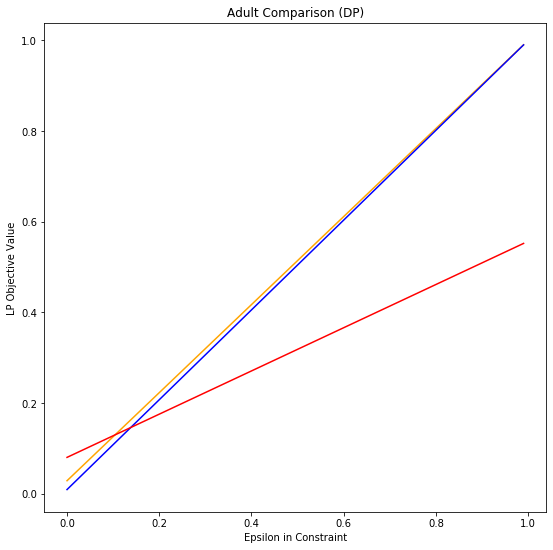

In [19]:
# Plot the constraints vs. objective values
plt.figure(figsize=(9,9))
plt.plot(epsilons, postprocessing_objective_values, 'orange')
plt.plot(epsilons, inprocessing_objective_values, 'blue')
plt.plot(epsilons, robust_objective_values, 'red')
plt.xlabel('Epsilon in Constraint')
plt.ylabel('LP Objective Value')
plt.title('Adult Comparison (DP)')